# Projet 2

## consigne

Mark, votre manager, vous a convié à une réunion pour vous présenter le projet d’expansion à l’international de l’entreprise. Il vous confie une première mission d’analyse exploratoire, pour déterminer si les données sur l’éducation de la banque mondiale permettent d’informer le projet d’expansion.

Voici les différentes questions que Mark aimerait explorer, que vous avez notées durant la réunion :

 - Quels sont les pays avec un fort potentiel de clients pour nos services ?
 - Pour chacun de ces pays, quelle sera l’évolution de ce potentiel de clients ?
 - Dans quels pays l'entreprise doit-elle opérer en priorité ?
Votre mission
Mark vous a donc demandé de réaliser une analyse pré-exploratoire de ce jeu de données. Il vous a transmis cet email à la suite de la réunion :

***
Hello,

Les données de la Banque mondiale sont disponibles à l’adresse suivante :

https://datacatalog.worldbank.org/dataset/education-statistics

Ou en téléchargement direct à ce lien.

Je te laisse regarder la page d'accueil qui décrit le jeu de données. En résumé, l’organisme “EdStats All Indicator Query” de la Banque mondiale répertorie 4000 indicateurs internationaux décrivant l’accès à l’éducation, l’obtention de diplômes et des informations relatives aux professeurs, aux dépenses liées à l’éducation... Tu trouveras plus d'info sur ce site :

http://datatopics.worldbank.org/education/

Pour la pré-analyse, pourrais-tu :

 - Valider la qualité de ce jeu de données (comporte-t-il beaucoup de données manquantes, dupliquées ?)
 - Décrire les informations contenues dans le jeu de données (nombre de colonnes ? nombre de lignes ?)
 - Sélectionner les informations qui semblent pertinentes pour répondre à la problématique (quelles sont les colonnes contenant des informations qui peuvent être utiles pour répondre à la problématique de l’entreprise ?)
 - Déterminer des ordres de grandeurs des indicateurs statistiques classiques pour les différentes zones géographiques et pays du monde (moyenne/médiane/écart-type par pays et par continent ou bloc géographique)
 
Ton travail va nous permettre de déterminer si ce jeu de données peut informer les décisions d'ouverture vers de nouveaux pays. On va partager ton analyse avec le board, alors merci de soigner la présentation et de l'illustrer avec des graphiques pertinents et lisibles !
***

Livrables attendus
 - Un notebook comportant les analyses pré-exploratoires réalisées (non cleané, pour comprendre votre démarche).
 - Un support de présentation pour la soutenance.

## import des bibliothèques

In [1]:
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
import math
import missingno as msno
import ipywidgets as widgets

from datetime import datetime, timezone, timedelta, date
from IPython.display import display as Idisplay
from IPython.display import clear_output
from ipywidgets.embed import embed_minimal_html
from matplotlib import pylab

import warnings
warnings.filterwarnings('ignore')

## import des données

In [2]:
EdStatsCountry = pd.read_csv("csv_data/EdStatsCountry.csv")
EdStatsCountry_Series = pd.read_csv("csv_data/EdStatsCountry-Series.csv")
EdStatsData = pd.read_csv("csv_data/EdStatsData.csv")
EdStatsFootNote = pd.read_csv("csv_data/EdStatsFootNote.csv")
EdStatsSeries = pd.read_csv("csv_data/EdStatsSeries.csv")

for t in np.unique(EdStatsSeries["Topic"]):
    print(f'\n{t}\n')
    print(np.unique(EdStatsSeries[["Topic", "Indicator Name"]][EdStatsSeries["Topic"]==t]))

## premier regard sur les données

premier coup d'oeuil avec une carte des liens entre les tables

![title](table_chart.png)

***
### affichage des données manquantes sous forme de matrice binaire (Noir = manquant, Blanc = présent)

In [3]:
Tables = [EdStatsCountry, EdStatsCountry_Series, EdStatsData, EdStatsFootNote, EdStatsSeries]
T_Names = ["EdStatsCountry", "EdStatsCountry-Series", "EdStatsData", "EdStatsFootNote", "EdStatsSeries"]
for t,n in zip(Tables, T_Names):
    t.name = n
Stats = {}

def draw_missing_values(ds_str, fig, ax):
    t = Tables[T_Names.index(ds_str)]
    check = np.vectorize(lambda x : x!=x)
    Stats[t.name] = {"missing" : check(t.to_numpy()), "data" : t}
    msno.matrix(t, ax=ax, sparkline=False)
    ax.set_title(t.name)
    fig.tight_layout(pad=2)

<IPython.core.display.Javascript object>


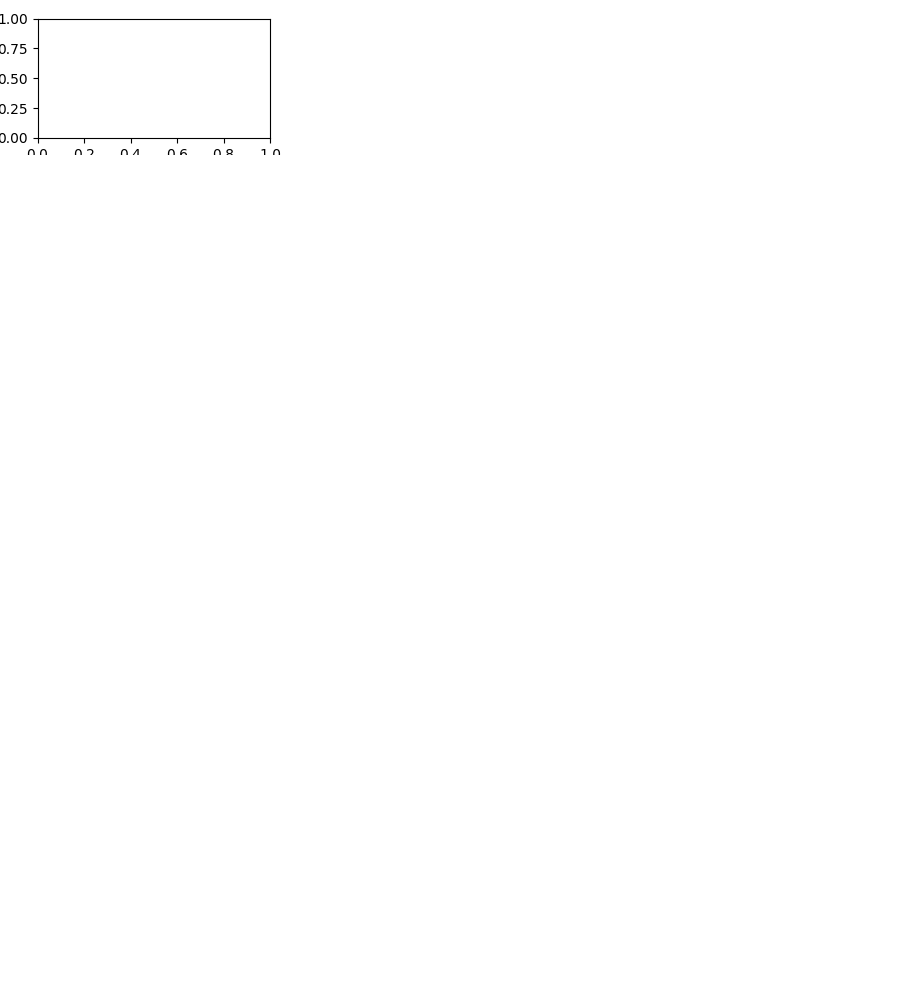

Dropdown(options=('EdStatsCountry', 'EdStatsCountry-Series', 'EdStatsData', 'EdStatsFootNote', 'EdStatsSeries'…

In [4]:
msnowidget = widgets.Dropdown(options=T_Names)

fig, ax = plt.subplots(figsize=(9,10))

def msnowidget_eventhandler(change):
    draw_missing_values(change.new, fig, ax)

msnowidget.observe(msnowidget_eventhandler, names='value')
Idisplay(msnowidget)

***
### sélection des indicateurs pertinents

In [5]:
indicators = np.unique(EdStatsData["Indicator Name"].to_numpy())

selection_mask = np.array([n in indicators for n in EdStatsSeries["Indicator Name"]])
selection_codes = EdStatsSeries["Series Code"][selection_mask].to_numpy()

countries = np.unique(EdStatsData["Country Name"].to_numpy())

code_mask = np.array([c in selection_codes for c in EdStatsData["Indicator Code"]])
state_mask = np.array([c in countries for c in EdStatsData["Country Name"]])

In [6]:
def get_Y_values(dataframe, indicator:str, country:str):
    X_string = [str(x.year) for x in X]
    indicator_mask = np.array([i == indicator for i in EdStatsData["Indicator Name"].to_numpy()])
    country_mask = np.array([c == country for c in EdStatsData["Country Name"].to_numpy()])
    return EdStatsData[X_string][indicator_mask*country_mask].to_numpy().ravel()

def get_indi_missing(dataframe, indicator:str):
    X_string = [str(x.year) for x in X]
    indicator_mask = np.array([i == indicator for i in EdStatsData["Indicator Name"].to_numpy()])
    N = len(EdStatsData[X_string][indicator_mask].to_numpy().ravel())
    return EdStatsData[X_string][indicator_mask].isna().sum(axis=1).to_numpy(), EdStatsData[X_string][indicator_mask].isna().sum(axis=0).to_numpy(), N

def get_cty_missing(dataframe, country:str):
    X_string = [str(x.year) for x in X]
    country_mask = np.array([c == country for c in EdStatsData["Country Name"].to_numpy()])
    N = len(EdStatsData[X_string][country_mask].to_numpy().ravel())
    return EdStatsData[X_string][country_mask].isna().sum(axis=1).to_numpy(), EdStatsData[X_string][country_mask].isna().sum(axis=0).to_numpy(), N

In [7]:
X = [date(year, 1, 1) for year in list(range(1970,2018,1))+list(range(2020,2101,5))]
X_string = [str(x.year) for x in X]

In [8]:
dates = X
options = [(d.strftime('%Y'), d) for d in dates]
date_slider = widgets.SelectionRangeSlider(options=options,
                                           index=(0,55),
                                           description='Période',
                                           disabled=False)

indicators_combobox = widgets.Combobox(
    value='Population, total',
    placeholder='',
    options=list(indicators),
    description='Indicator',
    ensure_option=True,
    disabled=False
)

countries_combobox = widgets.Combobox(
    value='France',
    placeholder='',
    options=list(countries),
    description='Country',
    ensure_option=True,
    disabled=False
)

In [9]:
class Displayer :
    
    def __init__(self, DS, code, country):
        self.dataset = DS
        self.code = code
        self.country = country
        self.X = np.array(dates)
        self.d_start = min(self.X)
        self.d_end = max(self.X)
        self.mask = np.full(len(self.X), True)
        self.fig, self.ax = None, None
        self.fig1, self.ax1 = None, None
        self.fig2, self.ax2 = None, None
        self.out = widgets.Output()
        self.indi_miss = widgets.Output()
        self.cty_miss = widgets.Output()
    
    def change_dates(self, new_date_start, new_date_end):
        self.d_start = new_date_start
        self.d_end = new_date_end
        self._UPDATE_MASK()
    
    def change_country(self, new_country):
        self.country = new_country
    
    def change_code(self, new_code):
        self.code = new_code
    
    def _UPDATE_MASK(self):
        self.mask = np.array([self.d_start <= date <= self.d_end for date in self.X])
    
    def _plot(self):
        self.out.clear_output()
        with self.out :
            if self.fig==None :
                self.fig, self.ax = plt.subplots(figsize=(9,6), 
                                                 num=f"{self.country}-{self.code}")
            else :
                self.fig.set(label = f"{self.country}-{self.code}")
            fig, ax = self.fig, self.ax
            ax.clear()
            ax.plot(self.X[self.mask], 
                    get_Y_values(self.dataset, self.code, self.country)[self.mask],
                    zorder=1)

            ax.grid(zorder=0)
            fig.tight_layout()
            Idisplay(fig)
    
    def _indicator_missing(self):
        self.indi_miss.clear_output()
        with self.indi_miss :
            if self.fig1==None :
                self.fig1, self.ax1 = plt.subplots(3, 1, 
                                                   figsize=(9,35), 
                                                   height_ratios = [15,10,5], 
                                                   num=f"{self.code[:50]}")
            else :
                self.fig1.set(label = f"{self.code[:50]}")
            fig1, ax1 = self.fig1, self.ax1
            miss_tab, miss_date, N = get_indi_missing(self.dataset, self.code)
            k = list(countries).index(self.country)
            
            ax1[0].clear()
            bars = ax1[0].barh(range(len(miss_tab)), miss_tab/max(miss_tab))
            bars[k].set_color('r')
            ax1[0].set_title(f'valeurs manquantes par pays')
            ax1[0].set_yticks([])
            ax1[0].set_ylim(-1, len(miss_tab)+1)
            
            ax1[1].clear()
            bars = ax1[1].barh(range(len(miss_date)), miss_date/max(miss_date))
            ax1[1].set_title(f'valeurs manquantes par année')
            ax1[1].set_ylim(-1, len(miss_date)+1)
            ax1[1].set_yticks(range(65), X_string)
            
            ax1[2].clear()
            ax1[2].pie([miss_tab.sum()/N, 1-(miss_tab.sum()/N)], 
                        labels=['missing', 'data'],
                        autopct='%1.1f%%')
            ax1[2].set_title(f'valeurs manquantes par pays -moyenne-')
            ax1[2].axis('equal')
            
            fig1.tight_layout()
            Idisplay(fig1)
    
    def _country_missing(self):
        self.cty_miss.clear_output()
        with self.cty_miss :
            if self.fig2==None :
                self.fig2, self.ax2 = plt.subplots(3, 1,
                                                   figsize=(9,115), 
                                                   height_ratios = [100,10,5],
                                                   num=f"{self.country}")
            else :
                self.fig2.set(label = f"{self.country}")
            fig2, ax2 = self.fig2, self.ax2
            miss_tab, miss_date, N = get_cty_missing(self.dataset, self.country)
            k = list(indicators).index(self.code)
            
            ax2[0].clear()
            bars = ax2[0].barh(range(len(miss_tab)), miss_tab/max(miss_tab))
            bars[k].set_color('r')
            ax2[0].set_title(f'valeurs manquantes par indicateur')
            ax2[0].set_yticks([])
            ax2[0].set_ylim(-1, len(miss_tab)+1)
            
            ax2[1].clear()
            bars = ax2[1].barh(range(len(miss_date)), miss_date/max(miss_date))
            ax2[1].set_title(f'valeurs manquantes par année')
            ax2[1].set_ylim(-1, len(miss_date)+1)
            ax2[1].set_yticks(range(65), X_string)
            
            ax2[2].clear()
            ax2[2].pie([miss_tab.sum()/N, 1-(miss_tab.sum()/N)], 
                        labels=['missing', 'data'],
                        autopct='%1.1f%%')
            ax2[2].set_title(f'valeurs manquantes par indicateur -moyenne-')
            ax2[2].axis('equal')
            
            fig2.tight_layout()
            Idisplay(fig2)
    
    def display(self):
        self._plot()
        self._indicator_missing()
        self._country_missing()

In [10]:
D = Displayer(EdStatsData, "Population, total", "France")

def date_slider_eventhandler(change):
    D.change_dates(*change.new)
    D.display()
def indicators_combobox_eventhandler(change):
    D.change_code(change.new)
    D.display()
def countries_combobox_eventhandler(change):
    D.change_country(change.new)
    D.display()

date_slider.observe(date_slider_eventhandler, names='value')
indicators_combobox.observe(indicators_combobox_eventhandler, names='value')
countries_combobox.observe(countries_combobox_eventhandler, names='value')

In [11]:
tab = widgets.Tab()
tab.children = [widgets.VBox([D.out, date_slider, indicators_combobox, countries_combobox]), 
                widgets.VBox([D.indi_miss, indicators_combobox]),
                widgets.VBox([D.cty_miss, countries_combobox])]
tab.titles = ("plot", "indicator", "country")
Idisplay(tab)
D.display()

***
communication : 'Internet users (per 100 people)', 'Personal computers (per 100 people)'

education : 'Enrolment in tertiary education, all programmes, both sexes (number)'
'Enrolment in secondary education, both sexes (number)'
'Enrolment in primary education, both sexes (number)'

geography : 'Region'

Economics : 'Income group', 'GNI per capita, Atlas method (current US$)'

T = EdStatsSeries[["Topic", "Indicator Name"]].to_numpy()
for t in T:
    print(t[0][:50], t[1][:70], sep="|")